In [1]:
# Core imports
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE  # (Potential future use for imbalance handling)
from imblearn.ensemble import BalancedRandomForestClassifier  # (Currently unused)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

e:\MLOps\MLOps-Spotify\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
""" # Environment check, versions, and RNG seed
import sys, importlib, platform, subprocess

def ensure_xgboost():
    try:
        import xgboost as xgb
        return xgb
    except Exception as e:
        print("xgboost not found. Attempting installation via pip...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
            import xgboost as xgb
            return xgb
        except Exception as ie:
            print("Failed to install xgboost via pip. You can also install with:")
            print(" - uv add xgboost")
            raise ie

# xgb = ensure_xgboost()
import sklearn

print(f"Python: {sys.version.split()[0]} | Platform: {platform.platform()}")
print(f"pandas: {pd.__version__} | numpy: {np.__version__} | sklearn: {sklearn.__version__} | xgboost: {xgb.__version__}")

RANDOM_STATE = 42
print("RANDOM_STATE set to 42") """

' # Environment check, versions, and RNG seed\nimport sys, importlib, platform, subprocess\n\ndef ensure_xgboost():\n    try:\n        import xgboost as xgb\n        return xgb\n    except Exception as e:\n        print("xgboost not found. Attempting installation via pip...")\n        try:\n            subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])\n            import xgboost as xgb\n            return xgb\n        except Exception as ie:\n            print("Failed to install xgboost via pip. You can also install with:")\n            print(" - uv add xgboost")\n            raise ie\n\n# xgb = ensure_xgboost()\nimport sklearn\n\nprint(f"Python: {sys.version.split()[0]} | Platform: {platform.platform()}")\nprint(f"pandas: {pd.__version__} | numpy: {np.__version__} | sklearn: {sklearn.__version__} | xgboost: {xgb.__version__}")\n\nRANDOM_STATE = 42\nprint("RANDOM_STATE set to 42") '

In [2]:
# load data from kaggle
data_path=kagglehub.dataset_download("amitanshjoshi/spotify-1million-tracks")
df=pd.read_csv(f"{data_path}/spotify_data.csv")

In [4]:
df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [5]:
df.shape

(1159764, 20)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1159764 non-null  int64  
 1   artist_name       1159749 non-null  object 
 2   track_name        1159763 non-null  object 
 3   track_id          1159764 non-null  object 
 4   popularity        1159764 non-null  int64  
 5   year              1159764 non-null  int64  
 6   genre             1159764 non-null  object 
 7   danceability      1159764 non-null  float64
 8   energy            1159764 non-null  float64
 9   key               1159764 non-null  int64  
 10  loudness          1159764 non-null  float64
 11  mode              1159764 non-null  int64  
 12  speechiness       1159764 non-null  float64
 13  acousticness      1159764 non-null  float64
 14  instrumentalness  1159764 non-null  float64
 15  liveness          1159764 non-null  float64
 16  

In [7]:
df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1159764.0,659061.322,428549.154,0.0,289940.750,579881.500,1031689.250,1473395.000
popularity,1159764.0,18.383,15.886,0.0,5.000,15.000,29.000,100.000
year,1159764.0,2011.955,6.804,2000.0,2006.000,2012.000,2018.000,2023.000
danceability,1159764.0,0.537,0.184,0.0,0.413,0.550,0.677,0.993
energy,1159764.0,0.640,0.271,0.0,0.454,0.694,0.873,1.000
key,1159764.0,5.288,3.555,0.0,2.000,5.000,8.000,11.000
loudness,1159764.0,-8.981,5.682,-58.1,-10.829,-7.450,-5.276,6.172
mode,1159764.0,0.635,0.482,0.0,0.000,1.000,1.000,1.000
speechiness,1159764.0,0.093,0.127,0.0,0.037,0.051,0.089,0.971
acousticness,1159764.0,0.322,0.355,0.0,0.006,0.147,0.640,0.996


In [8]:
df.isna().sum()

Unnamed: 0           0
artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

In [3]:
df_clean = df.copy()

# Handle missing values
df_clean['artist_name'] = df_clean['artist_name'].fillna('Unknown Artist')
df_clean['track_name'] = df_clean['track_name'].fillna('Unknown Track')

# Create binary target
df_clean['is_popular'] = (df_clean['popularity'] > 60).astype(int)

# Check class distribution
print(df_clean['is_popular'].value_counts(normalize=True)*100)

is_popular
0    98.801998
1     1.198002
Name: proportion, dtype: float64


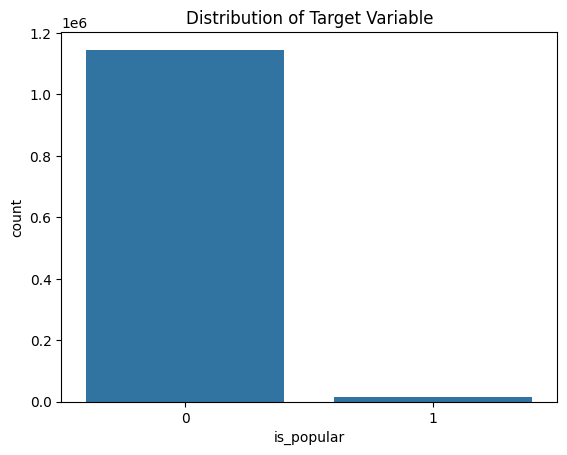

In [10]:
#show the ratio of target variable
df_clean['is_popular'].value_counts(normalize=True)
sns.countplot(x='is_popular', data=df_clean)
plt.title('Distribution of Target Variable')
plt.show()


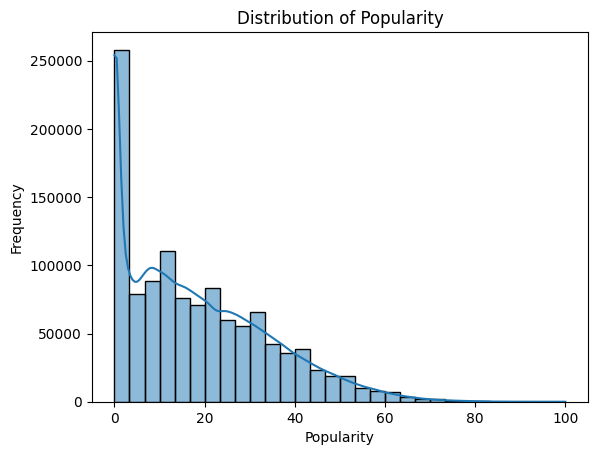

In [11]:
# plot popularity distribution
sns.histplot(df_clean['popularity'], bins=30, kde=True)
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

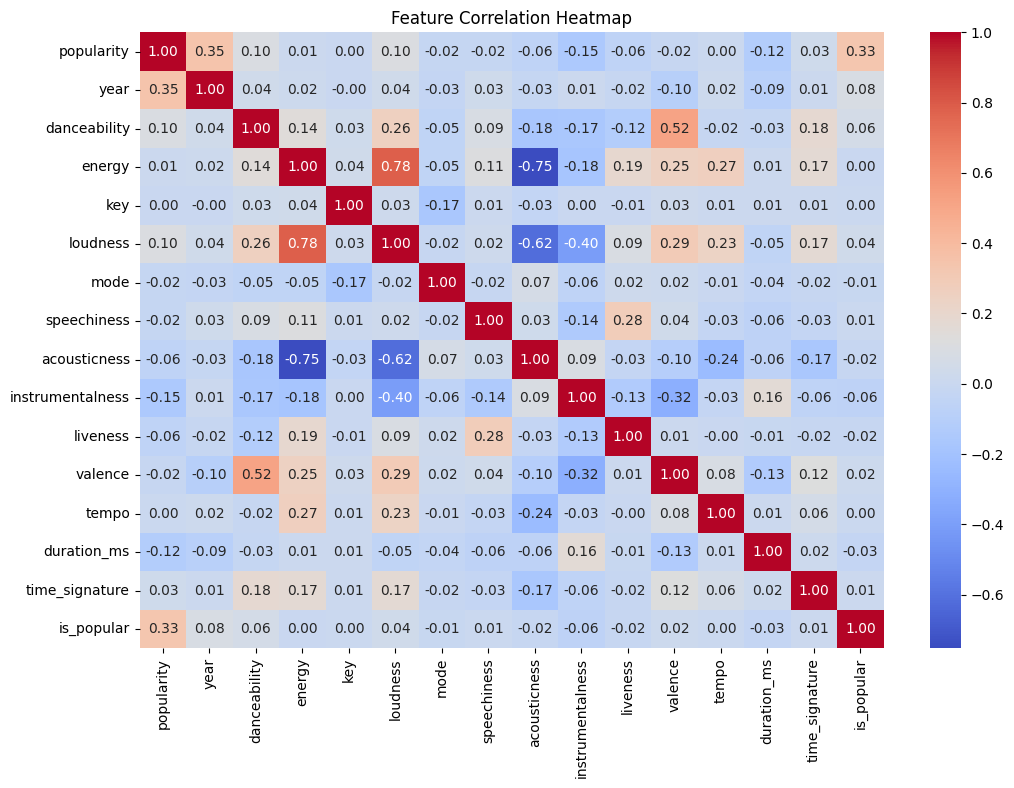

In [12]:
# plot heatmap of correlations (use numeric features only to avoid string->float conversion errors)
plt.figure(figsize=(12, 8))
numeric_df = df_clean.select_dtypes(include=[np.number]).drop(columns=['Unnamed: 0'], errors='ignore')
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [4]:
# Start with clean data
X = df_clean.copy()

# Drop unnecessary columns
# cols_to_drop = ['Unnamed: 0', 'track_id', 'popularity', 'popularity_tier', 'is_popular']
# X = X.drop([col for col in cols_to_drop if col in X.columns], axis=1)

In [14]:
# 1. Convert duration to minutes
# X['duration_minutes'] = X['duration_ms'] / 60000
# X['duration_minutes'] = X['duration_minutes'].round(2)
# X = X.drop('duration_ms', axis=1)

In [5]:
# 2. Artist features
print("   Creating artist features...")
artist_stats = X.groupby('artist_name').agg({'popularity': ['mean', 'max']}).round(3)
artist_stats.columns = ['artist_avg_pop', 'artist_max_pop']
artist_stats = artist_stats.reset_index()

X = X.merge(artist_stats, on='artist_name', how='left')
X.head()

   Creating artist features...


,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,is_popular,artist_avg_pop,artist_max_pop
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,...,0.6940,0.000000,0.1150,0.139,133.406,240166,3,1,25.207,68
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,...,0.4770,0.000014,0.0974,0.515,140.182,216387,4,0,25.207,68
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,...,0.3380,0.000050,0.0895,0.145,139.832,158960,4,0,27.754,60
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,...,0.8070,0.000000,0.0797,0.508,204.961,304293,4,0,37.398,65
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,...,0.0726,0.019300,0.1100,0.217,171.864,244320,4,0,31.955,59


In [6]:
# Create numeric artist features
# X['artist_experience'] = np.log1p(X['artist_track_count'])
# Safely convert artist_avg_pop into tiers while preserving NaNs using nullable Int
_artist_tier = pd.cut(X['artist_avg_pop'], bins=[0, 30, 60, 100], labels=[0, 1, 2])
X['artist_tier'] = _artist_tier.cat.codes.replace(-1, pd.NA).astype('Int64')

In [7]:
# 4. Temporal features
print("   Creating temporal features...")
X['years_since_release'] = 2025 - df_clean['year']
X['is_recent'] = (df_clean['year'] >= 2020).astype(int)
# Safely convert era into numeric categories with nullable Int
_era = pd.cut(df_clean['year'], bins=[1999, 2005, 2010, 2015, 2020, 2025],
              labels=['2000-2005', '2006-2010', '2011-2015', '2016-2020', '2021-2025'])
X['era'] = _era.cat.codes.replace(-1, pd.NA).astype('Int64')

   Creating temporal features...


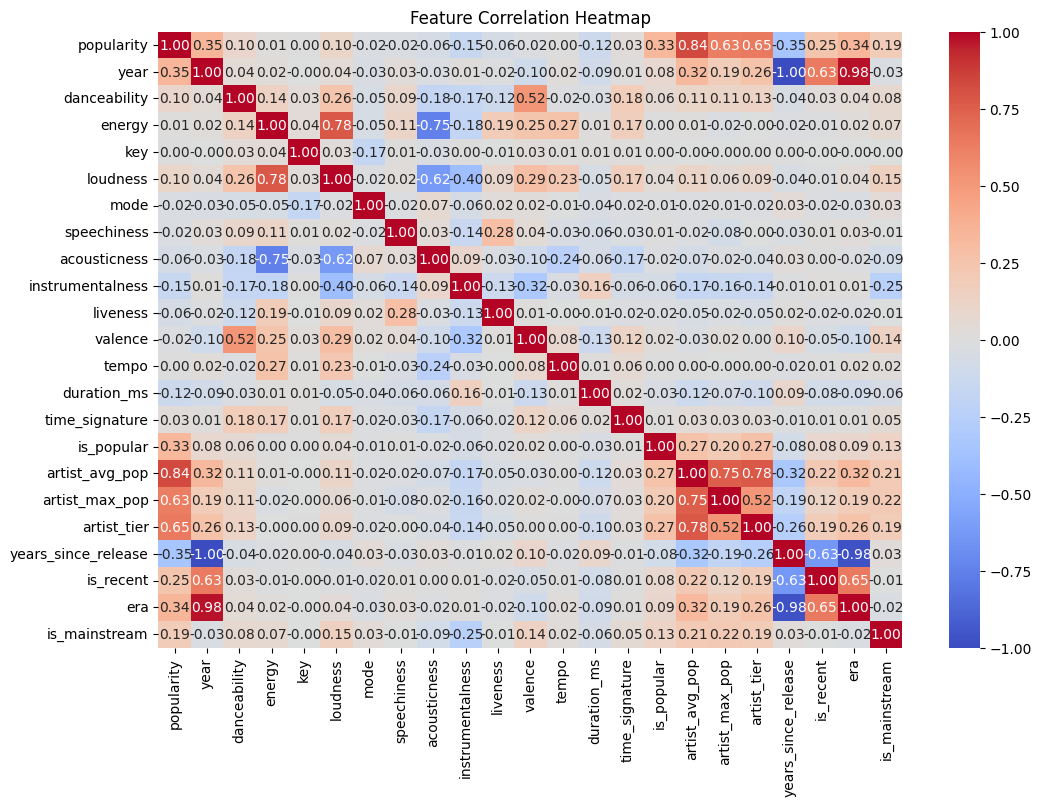

In [10]:
# plot heatmap of correlations (use numeric features only to avoid string->float conversion errors)
plt.figure(figsize=(12, 8))
x_df = X.select_dtypes(include=[np.number]).drop(columns=['Unnamed: 0'], errors='ignore')
correlation_matrix = x_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:




    







    # 5. Audio features
    print("   Creating audio features...")
    # Commercial appeal score
    X['commercial_appeal'] = (
        df['danceability'] * 0.3 +
        df['energy'] * 0.25 +
        (1 - df['acousticness']) * 0.2 +
        df['valence'] * 0.15 +
        ((df['loudness'] + 60) / 60) * 0.1
    ).round(3)

    # Music style indicators
    X['dance_track_potential'] = (df['danceability'] * df['energy']).round(3)
    X['chill_track_potential'] = (df['acousticness'] * (1 - df['energy'])).round(3)

    # Emotional characteristics
    X['happiness_score'] = (df['valence'] * df['energy']).round(3)

    # Duration features
    X['is_radio_friendly'] = ((X['duration_minutes'] >= 2.5) & 
                             (X['duration_minutes'] <= 4.0)).astype(int)

    # Normalized loudness
    X['normalized_loudness'] = ((df['loudness'] + 60) / 60).clip(0, 1).round(3)

    # Tempo category - use nullable Int to avoid conversion errors
    _tempo_cat = pd.cut(df['tempo'], bins=5, labels=[0, 1, 2, 3, 4])
    X['tempo_category'] = _tempo_cat.cat.codes.replace(-1, pd.NA).astype('Int64')

    # 6. Final feature preparation
    print("   Finalizing features...")

    # Separate features from identifiers
    feature_columns = [col for col in X.columns if col not in ['artist_name', 'track_name', 'genre', 'year']]
    X_features = X[feature_columns].copy()
    X_identifiers = X[['artist_name', 'track_name']].copy()

    # Ensure all features are numeric
    for col in X_features.columns:
        if X_features[col].dtype in ['object', 'category']:
            X_features[col] = pd.to_numeric(X_features[col], errors='coerce').fillna(0)

    # Handle any remaining missing values
    for col in X_features.columns:
        if X_features[col].isna().any():
            X_features[col] = X_features[col].fillna(X_features[col].median())

    print(f"✅ Feature engineering complete")
    print(f"   {X_features.shape[1]} numeric features created")
    print(f"   Artist and track names preserved for interpretability")

    return X_features, X_identifiers


   Creating temporal features...
   Creating audio features...


KeyError: 'duration_minutes'

In [ ]:
def train_model(X_features, X_identifiers, y):
    """Train and evaluate the popularity prediction model"""
    print("\n🚀 TRAINING MODEL...")

    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split data (maintaining alignment between features and identifiers)
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Split identifiers for test set
    _, X_test_ids, _, _ = train_test_split(
        X_identifiers, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    print(f"   Training set: {X_train.shape[0]:,} samples")
    print(f"   Test set: {X_test.shape[0]:,} samples")
    print(f"   Features: {X_train.shape[1]}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest model
    model = RandomForestClassifier(
        n_estimators=150,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    print("   Training in progress...")
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"✅ Model trained successfully!")
    print(f"📊 Test Accuracy: {accuracy:.3f}")

    return model, scaler, label_encoder, X_test, X_test_ids, y_test, y_pred, y_pred_proba
